In [90]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Read data
weather = pd.read_csv("daily-weather.csv")
solar = pd.read_csv("solar-output_daily.csv")

In [3]:
weather['Date'] = pd.to_datetime(weather['Date']).dt.date
solar['Timestamp'] = pd.to_datetime(solar['Timestamp']).dt.date

In [ ]:
df = pd.merge(weather, solar, left_on='Date', right_on='Timestamp')
df = df.reset_index(drop=True)
df.drop(columns=['Timestamp', 'New Nexus 1272 Meter', 'Inverters'], inplace=True)
df.to_csv("joined-weather-solar.csv")

Text(0, 0.5, 'kW')

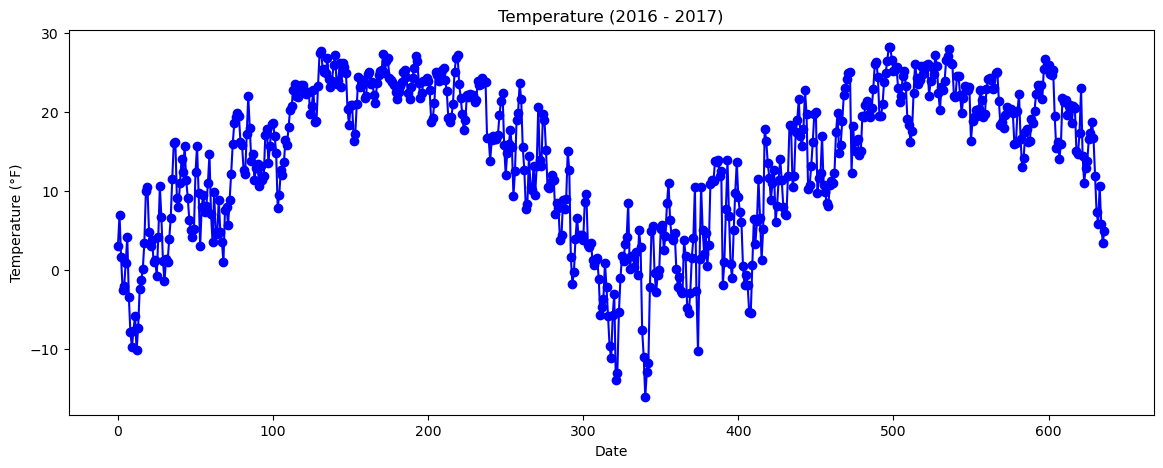

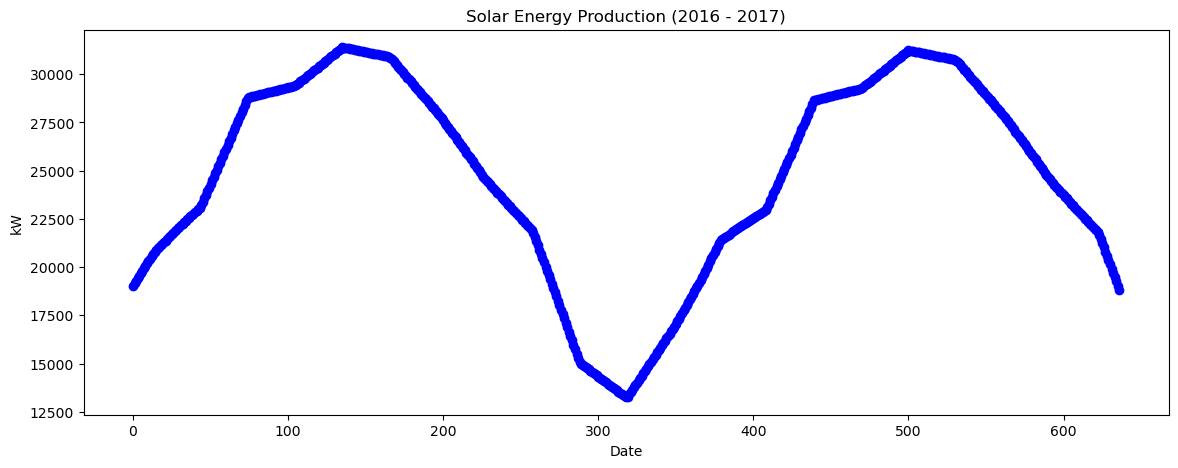

In [32]:
# Set 'Date' as the index
df.set_index('Date')
# Visualize the data
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Temperature'], marker='o', linestyle='-', color='b')
plt.title('Temperature (2016 - 2017)')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')

plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Site Performance Estimate'], marker='o', linestyle='-', color='b')
plt.title('Solar Energy Production (2016 - 2017)')
plt.xlabel('Date')
plt.ylabel('kW')

## Data Processing

In [99]:
df = pd.read_csv("joined-weather-solar.csv")
df['Date'] = pd.to_datetime(df['Date'])
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.month
df = df.drop(columns=['Date','Station pressure', 'Unnamed: 0', 'Altimeter'])
df = df.rename(columns={'Temperature':'temp',
                        'Dew point':'dew',
                        'Wind speed':'windspeed',
                        'Cloud coverage': 'cloudcover',
                        'Visibility': 'visibility',
                        'Solar energy': 'solarenergy',
                        'Relative humidity':'humidity'})

### Linear Regression

In [55]:


# Define features (x) and the target variable (y)
x = df.drop(columns='Site Performance Estimate')
y = df['Site Performance Estimate']

# Split the df into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit linear regression
regression = sm.OLS(y_train, x_train)
results = regression.fit()
print(results.summary())

# R-squared of the test training set
y_pred = results.predict(x_test)
print(f'The R-squared for the test set is {r2_score(y_test, y_pred)}')

                                    OLS Regression Results                                    
Dep. Variable:     Site Performance Estimate   R-squared (uncentered):                   0.990
Model:                                   OLS   Adj. R-squared (uncentered):              0.990
Method:                        Least Squares   F-statistic:                              5430.
Date:                       Sat, 18 Nov 2023   Prob (F-statistic):                        0.00
Time:                               16:33:38   Log-Likelihood:                         -4717.0
No. Observations:                        509   AIC:                                      9452.
Df Residuals:                            500   BIC:                                      9490.
Df Model:                                  9                                                  
Covariance Type:                   nonrobust                                                  
                    coef    std err          t    

In [50]:
# Remove insignificant features 
conf_int = results.conf_int()

# Filter features based on confidence intervals
not_significant = (conf_int[0]) > 0 & (conf_int[1] < 0)
not_significant

Cloud coverage        True
visibility            True
temp                  True
dew                  False
Relative humidity    False
windspeed            False
solarenergy           True
year                  True
month                False
dtype: bool

In [38]:
# Remove insignificant features based on their confidence intervals
x_train_sign = x_train[['Cloud coverage', 'Solar energy']]
x_test_sign = x_test[['Cloud coverage', 'Solar energy']]

# Refit the linear regression
model2 = sm.OLS(y_train, x_train_sign)
results2 = model2.fit()
print(results2.summary())

y_pred2 = results2.predict(x_train_sign)
# R-squared of the test training set
print(f'The R-squared for the test set is {r2_score(y_test, y_pred)}')

                                    OLS Regression Results                                    
Dep. Variable:     Site Performance Estimate   R-squared (uncentered):                   0.970
Model:                                   OLS   Adj. R-squared (uncentered):              0.969
Method:                        Least Squares   F-statistic:                              5387.
Date:                       Sat, 18 Nov 2023   Prob (F-statistic):                        0.00
Time:                               16:14:25   Log-Likelihood:                         -4996.4
No. Observations:                        509   AIC:                                      9999.
Df Residuals:                            506   BIC:                                  1.001e+04
Df Model:                                  3                                                  
Covariance Type:                   nonrobust                                                  
                     coef    std err          t   

### LSTM

In [112]:
# Splitting the df into features and target
X = df.drop(columns=['Site Performance Estimate'], axis=1)
y = df['Site Performance Estimate']

# Splitting the dfset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizing the df
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Building the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics='mean_squared_error')

In [113]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,         
                               restore_best_weights=True) 

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
14/14 [==============================] - 2s 20ms/step - loss: 652037760.0000 - mean_squared_error: 652037760.0000 - val_loss: 627107008.0000 - val_mean_squared_error: 627107008.0000
Epoch 2/100
14/14 [==============================] - 0s 9ms/step - loss: 651940928.0000 - mean_squared_error: 651940928.0000 - val_loss: 626960960.0000 - val_mean_squared_error: 626960960.0000
Epoch 3/100
14/14 [==============================] - 0s 8ms/step - loss: 651698176.0000 - mean_squared_error: 651698176.0000 - val_loss: 626577088.0000 - val_mean_squared_error: 626577088.0000
Epoch 4/100
14/14 [==============================] - 0s 9ms/step - loss: 651060032.0000 - mean_squared_error: 651060032.0000 - val_loss: 625596096.0000 - val_mean_squared_error: 625596096.0000
Epoch 5/100
14/14 [==============================] - 0s 9ms/step - loss: 649558528.0000 - mean_squared_error: 649558528.0000 - val_loss: 623418304.0000 - val_mean_squared_error: 623418304.0000
Epoch 6/100
14/14 [===============

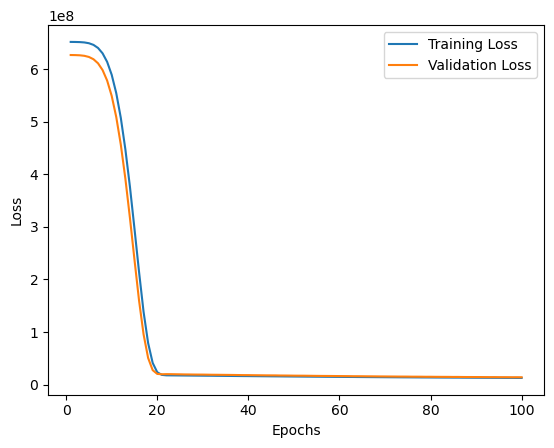

In [114]:
# Create a range of epochs
best_epoch = 100
epochs = range(1, best_epoch+1)

# Plot training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

## AdaBoost

In [101]:
X = df.drop(columns=['Site Performance Estimate'], axis=1)
y = df['Site Performance Estimate']

# Splitting the dfset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizing the df
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [105]:
# Define the AdaBoostRegressor with the base estimator and a range of hyperparameters
ada_regressor = AdaBoostRegressor(base_estimator=None, random_state=42)

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],           
    'learning_rate': [0.01, 0.1, 0.5, 1.0]   
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=ada_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and best estimator from the grid search
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Evaluate the best estimator on the test data using mean squared error (MSE)
final_ada = best_estimator.fit(X_train, y_train)
y_pred = final_ada.predict(X_test)
r2 = final_ada.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Best model: {best_estimator}")
print(f"R-squared on Test Data: {r2}")
print(f"Root Mean Squared Error (MSE) on Test Data: {rmse:.2f}")

Best model: AdaBoostRegressor(base_estimator=None, learning_rate=0.5, n_estimators=150,
                  random_state=42)
R-squared on Test Data: 0.9527212231238956
Root Mean Squared Error (MSE) on Test Data: 1130.51
